# Exercise 7: Model Optimization


While for ordinary least squares regression we could directly compute parameters that yielded the best model, there is not such a closed-form solution anymore when we introduce a regularization term.
In this exercise we take a look into the way that the ridge regression models, and actually most other regularized regression models are fit.

In [4]:
import numpy as np

Once again, we use the Iris dataset to test our models on. The target variable is *petal width*, on we want to regress it from the three other numerical attributes.

In [5]:
from sklearn import datasets
dta = datasets.load_iris()
#print(dta.DESCR)

### Task 1: Exploring the Loss Function


In lecture we have learned that in *ridge regression*, we want to minimize the loss function 
$$
L(\beta) = \sum_{i=1}^n \left(y_i-\beta_0-\sum_{j=1}^p\beta_j x_{ij}\right)^2 + \lambda \sum_{j=1}^p \beta_j^2.
$$

#### a) Implementing the Loss

Implement a function that computes the value of the loss function, using the signature in the cell below. Assume that the first column of your input matrix $X$ has all-constant values $1$ to model the intercept. 

In [6]:
# X: 2-dimensional numpy array of features 
# y: 1-dimensional array of target values
# beta: current parameter vector
# reg: regularization term lambda (float)

def loss(X,y,beta,reg):
    #X = np.insert(X, 0, values=1, axis=1) # add a column of ones s.t. y=X*b
    sse = np.sum(np.square(np.dot(X,beta) - y))
    norm = np.sum(np.square(beta))
    return sse + reg*norm

#### b) Convexity of the Loss

We explore the cost function with a practical example. Load the Iris dataset from sklearn, and set up a univariate regression in which you predict petal width from petal length.
Set  $\beta_0 = mean(y)$ and $\lambda = 1$, and plot the value of the cost function against $\beta_1$ for  $\beta_1 \in\{-10,-9.9,\dots,9.9,10\}$.  
Is there a unique minimum? What is the sign of the derivative at $\beta = -3$ and $\beta = 3$? In which direction does it point - in direction of the minimum or against it?

In [7]:
X = np.array([dta.data[:,2]]).T
X = np.insert(X, 0, values=1, axis=1)

y = dta.data[:,3]
b0 = np.mean(y)
losses = []
iv = np.arange(-10,10, step = 0.1)
for b1 in iv:
    losses.append(loss(X,y,np.array([b0,b1]),1))

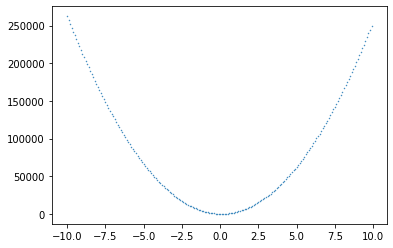

In [9]:
from matplotlib import pyplot as plt

plt.scatter(iv,losses,s=0.2)
plt.show()

__Answer:__ We observe that this loss function is convex (i.e., if we connect any two points in the plot with a line, this line would be above the graph), and thus there is a unique minimum. Note that this would also hold if we were to 3D-plot the loss with respect to $\beta_0$ and $\beta_1$, and also for higher-dimensional vectors $\beta$.  
At $\beta=-3$, the loss funtion appears to be falling, and thus the slope is negative, i.e. the derivative has negative sign. However, the minimum is in positive direction, and thus it points in the opposite direction of the minimum. Thus, if we wanted to wander toward the minimum from $\beta=-3$, we would have to wander against the direction of the gradient.  
The analogous case holds for $\beta=3$, only with opposite signs/direction.

### Task 2: Introducing Gradient Descent

In practice, regularized regression models regression is usually optimized by a variant of gradient descent, which is a conpetually simple iterative procedure, in which you first initialize $\beta$ at random, and then, until convergence, one updates
$$\beta^{new} \gets \beta^{old} - \alpha\cdot \nabla L(\beta^{old}), $$
where $\alpha$ is the so-called learning rate, and $\nabla L(\beta)$ the gradient of the loss function with respect to $\beta$.
In practice one usually selects a convergence tolerance $\epsilon>0$ and stops the iteration when $|L(\beta^{new}) - L(\beta^{old})| < \epsilon$.

#### a) Computing the gradient
Grab a pen and a piece of paper and compute the partial derivatives $$\frac{\partial C(\beta)}{\partial \beta_k}$$ for $k=0$ and $k>0$. Judging the resulting derivatives, give a reason why it is not ideal when the features are not standardized.

**Solution**: 

$$
\frac{\partial C(\beta)}{\partial \beta_k} = \sum_{i=1}^n -2x_{ik} \left(y_i-\beta_0-\sum_{j=1}^p\beta_j x_{ij}\right) + 2\alpha\beta_k
$$
For $\beta_0$, we get the same result, only that we would have $x_{ik}=1$.

#### b) Implementing Gradient Descent for Ridge Regression
Implement a function that optimizes a ridge regression model via gradient descent, using the function signature in the cell below. Initialize your model in a way that $\beta_0$ equals the mean of $y$ and all other elements of $\beta$ are drawn from the standard normal distribution.

Test your model on the **scaled** iris data to predict the petal width from all other columns, using $\lambda = 1$, $\alpha=0.001$, $\epsilon=10^{-6}$!

In [10]:
# INPUT VALUES
# X: 2-dimensional numpy array of features 
# y: 1-dimensional array of target values
# reg: regularization term lambda (float)
# alpha: learning rate (float)
# eps: convergence treshold (float)
# max_iter: maximum number of iterations in gradient descent (int) 
# -> break iteration when that number is reached even is we have not yet converged
#
# OUTPUT values:
#
# beta: numpy array containing optimal coefficients
# n_it: number of iterations
# losses: vector of loss function values in every iteration

def ridge_GD(X,y,reg,alpha,eps,max_iter=10000): 
    n = (np.shape(X)[0])
    p = np.shape(X)[1] # p is the number of variables in the multiple regression
    
    # initilize beta vector
    b = np.random.normal(size=p+1)
    b[0] = np.mean(y)
    X = np.insert(X, 0, values=1, axis=1) # add a column of ones s.t. y=X*b

    # initialize losses
    losses = [loss(X,y,b,reg)]
    n_it = 0
    diff = eps+1
    
    # now the gradient descent:
    while n_it < max_iter and diff > eps:
        
        b_old = np.copy(b)
        res = (y - np.dot(X,b)) # residual from prediction with current beta
        
        # gradient computation can be written in a compact way
        d_b = (-1)*np.dot(X.T,(2*res))+2*reg*b # derivative w.r.t. b
        
        # parameter update
        b = b_old - alpha*d_b # b = b -1/n * learning_rate*gradient(f)
        losses.append(loss(X,y,b,reg))
        diff = np.linalg.norm(losses[-1]-losses[-2])
        
        n_it+=1
      
    if n_it >=max_iter:
        print("Iteration has not yet converged")
        
    return b, n_it, losses

In [15]:
from sklearn.preprocessing import StandardScaler
X = dta.data[:,:-1]
y = dta.data[:,-1]
scaler = StandardScaler()
X=scaler.fit_transform(X)

beta,n_it,losses = ridge_GD(X,y,reg=1,alpha=1e-03,eps=1e-06)
print(beta)
print(n_it)

[ 1.19139073 -0.1272431   0.07930119  0.87050427]
303


In [14]:
from sklearn import linear_model
# our solution roughly cooresponds to sklearn's ridge regression
rr = linear_model.Ridge(alpha=1)
rr = rr.fit(X,y)
print((rr.intercept_,rr.coef_))

(1.199333333333335, array([-0.12810076,  0.0796349 ,  0.87146313]))


#### c) The Effect of the Learning Rate

Reoptimize your model using different learning rates $\alpha \in \{10^{-i} : i\in\{1,2,3,4,5,6\}\}$.
What are the effects on your optimization?

In [27]:
for alpha in [1e-01,1e-02,1e-03,1e-04,1e-05,1e-06]:
    beta,n_it,losses = ridge_GD(X,y,reg=1,alpha=alpha,eps=1e-06)
    print((alpha,n_it,beta,losses[-1]))


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in square
  if __name__ == '__main__':
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


(0.1, 88, array([ 1.22789174e+141, -4.95088303e+155,  2.84228169e+155,
       -5.41760005e+155]), inf)
(0.01, 218, array([ 1.22897555e+139, -6.56186036e+153,  3.76713719e+153,
       -7.18044333e+153]), inf)
(0.001, 305, array([ 1.19139073, -0.12724653,  0.07930252,  0.8705081 ]), 7.64236731036566)
(0.0001, 2160, array([ 1.19139073, -0.12534369,  0.07856213,  0.86838075]), 7.642559883046041)
Iteration has not yet converged
(1e-05, 10000, array([1.19139073, 0.00911081, 0.02624584, 0.71806213]), 8.169954231387898)
Iteration has not yet converged
(1e-06, 10000, array([ 1.19177816, -1.18132321,  0.49142224,  2.04939312]), 38.76020716590014)


__Answer:__ If the learning rate is too big, we actually keep leaping over the minimum, in a way that with each update, we even end up further away from the minimum. Contrarily, of the learning rate is too low, we just take much longer to converge to the minimum.  
Note that for these reason, in practice one applies dynamic learning rates, which however are beyond the scope of this lecture. 

### Task 3: Stochastic Gradient Descent 

Note that in practice, the datasets that are optimized on are often very large. When optimizing the model, this has the particular effect that the sum becomes very large and thus takes very long to be computed. one often uses more advanced techniques such as stochastic gradient descent (SGD) to accelerate the iteration.
The idea behind SGD is to only consider a subset (batch) of samples which is randomly drawn from the full data. That way, we only have to sum over the small subset of samples, which significantly accelerates each iteration step. While this optimizes the cost function in a rather noisy way, and usually takes more single iteration steps, this approach still saves much computation time on large datasets.

#### a) Implementing SGD
Adapt your code from task 2 to implement stochastic gradient descent! Apply your model on the scaled iris data with batch size 10, and all other parameters as in 2a)!

In [30]:
# INPUT VALUES
# X: 2-dimensional numpy array of features 
# y: 1-dimensional array of target values
# reg: regularization term lambda (float)
# batch_size: (int)
# alpha: learning rate (float)
# eps: convergence treshold (float)
# max_iter: maximum number of iterations in gradient descent (int) 
# -> break iteration when that number is reached even is we have not yet converged
#
# OUTPUT values:
#
# beta: numpy array containing optimal coefficients
# n_it: number of iterations
# losses: vector of loss function values in every iteration

def ridge_SGD(X,y,reg,batch_size,alpha,eps,max_iter=1e05):
    
    n = (np.shape(X)[0])
    p = np.shape(X)[1] # p is the number of variables in the multiple regression
    b = np.random.normal(size=p+1)
    b[0] = np.mean(y)
    X = np.insert(X, 0, values=1, axis=1) # add a column of ones s.t. y=X*b

    losses = [loss(X,y,b,reg)]
    n_it = 0
    diff = eps+1
    
    # now the gradient descent:
    while n_it < max_iter and diff > eps:
        
        # draw indices of batch here
        batch_ind = np.random.choice(n, size=batch_size, replace=False, p=None)
        
        b_old = np.copy(b)
        
        # onl consider samples in current batch
        res = (y[batch_ind] - np.dot(X[batch_ind],b))
        
        # derivative w.r.t. b on current batch
        d_b = (-1)*np.dot(X[batch_ind].T,(2*res))+2*reg*b 
        
        # now parameter upodate as before
        b = b_old - alpha*d_b # b = b -1/n * learning_rate*gradient(f)

        losses.append(loss(X,y,b,reg))
        diff = np.linalg.norm(losses[-1]-losses[-2])

        n_it+=1
      
    if n_it >=max_iter:
        print("Iteration has not yet converged")
        
    return b, n_it, losses

#### b) Experimenting with Batch Sizes
Reoptimize your model multiple times with fixed batch sizes in $\{1,5, 10,20,30,50\}$. What effects do you observe?

In [33]:
for batch_size in [1,5,10,20,30,50]:
    for _ in range(5):
        beta,n_it,losses = ridge_SGD(X,y,reg=1,batch_size=batch_size,alpha=1e-03,eps=1e-06)
        print((batch_size,n_it,beta,losses[-1]))


(1, 32648, array([ 0.59578457,  0.18311179, -0.0666366 ,  0.26463681]), 75.47578214786498)
Iteration has not yet converged
(1, 100000, array([ 0.59556358,  0.18309987, -0.07345723,  0.2522746 ]), 76.40666361896335)
(1, 30865, array([ 0.59734585,  0.1989054 , -0.07664913,  0.27808831]), 73.06712328014015)
(1, 81610, array([ 0.59809556,  0.20313632, -0.0635151 ,  0.2692286 ]), 73.6434033813567)
(1, 56969, array([ 0.59853453,  0.1742241 , -0.04715589,  0.26294289]), 76.18131151173985)
(5, 14229, array([ 1.0101501 ,  0.17932525, -0.05405334,  0.47210221]), 16.13386796673647)
(5, 88684, array([ 0.9959433 ,  0.17519356, -0.05223313,  0.46190852]), 17.237735732558104)
Iteration has not yet converged
(5, 100000, array([ 0.99636925,  0.18274903, -0.04297986,  0.47034655]), 16.955282350701076)
Iteration has not yet converged
(5, 100000, array([ 0.99665048,  0.17803087, -0.0477636 ,  0.46141614]), 17.191957577599183)
(5, 17447, array([ 1.01038767,  0.17584984, -0.05642789,  0.46443762]), 16.33688

__Answer:__ We generally need more iterations, though the exact number also strongly depends on the drawn batches. Further, the small batch sizes may result in small gradients, with a chance of braking the iteration too early due to a small update.  
Yet, in practice SGD is still often preferred over standard GD, however when having small datasets like in our case, it is not necessarily the best choice as we can see here.